# Run Simulator GUI

In [1]:
import math
import time
import numbers
import numpy as np
from PIL import Image
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from ipywidgets import FloatSlider, IntSlider, Dropdown, Layout, interact

from lib.util import plot_XY_function_graph
from lib.cnn import ImageUtil, CNN, CNNTemplate, CNNSimulator
from lib.cnn_template import CNNTemplateLib
from lib.ode import rk4_system_algorithm, rk4_system_method, rkacem_system_method, ode_methods

### prepare image and template run simulation

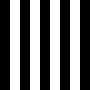

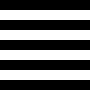

A=[[0 0 0]
 [0 3 0]
 [0 0 0]]
B=[[0 0 0]
 [0 3 0]
 [0 0 0]]
I=2


In [2]:
# setup image from encoding
ImageUtil.save_image_from_nparray(np.array(
    [[+1, -1, +1, -1, +1, -1, +1, -1, +1],
    [+1, -1, +1, -1, +1, -1, +1, -1, +1],
    [+1, -1, +1, -1, +1, -1, +1, -1, +1],
    [+1, -1, +1, -1, +1, -1, +1, -1, +1],
    [+1, -1, +1, -1, +1, -1, +1, -1, +1],
    [+1, -1, +1, -1, +1, -1, +1, -1, +1],
    [+1, -1, +1, -1, +1, -1, +1, -1, +1],
    [+1, -1, +1, -1, +1, -1, +1, -1, +1],
    [+1, -1, +1, -1, +1, -1, +1, -1, +1]]
), "image/input.png", display_scale=10)


ImageUtil.save_image_from_nparray(np.array(
    [[+1, +1, +1, +1, +1, +1, +1, +1, +1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [+1, +1, +1, +1, +1, +1, +1, +1, +1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [+1, +1, +1, +1, +1, +1, +1, +1, +1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [+1, +1, +1, +1, +1, +1, +1, +1, +1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [+1, +1, +1, +1, +1, +1, +1, +1, +1]]
), "image/state.png", display_scale=10)


template = CNNTemplate(
    A=np.array(
        [[0, 0, 0],
        [0, 3, 0],
        [0, 0, 0]]
    ),
    B=np.array(
        [[0, 0, 0],
        [0, 3, 0],
        [0, 0, 0]]
    ),
    I=2
)
print(template)

### Using interactive widget

In [3]:
# @widgets.interact(
#     time=FloatSlider(min=0, max=20, step=.1, value=1, layout=Layout(width='600px')),
#     step_size=FloatSlider(min=.1, max=5, step=.1, value=1, layout=Layout(width='600px')),
#     max_tol_dym=".01"
# )
ode_methods_name = list(ode_methods.keys())
@widgets.interact(
    ode_method = ode_methods_name,
    time=FloatSlider(min=0, max=20, step=.1, value=1, layout=Layout(width='600px')),
    step_size=FloatSlider(min=.1, max=5, step=.1, value=1, layout=Layout(width='600px')),
    tol=".01",
    max_tol_dym=".01"
)
def run_hole_fill_simulator(ode_method, time, step_size,tol, max_tol_dym):
    
    cnn_input = ImageUtil.convert_image2bipolar_encode(Image.open("image/input.png"))
    cnn_state = ImageUtil.convert_image2bipolar_encode(Image.open("image/state.png"))
    
    cnn = CNN(cnn_input, cnn_state, template)
    
    simulator = CNNSimulator(cnn)
    # simulator.step_size = step_size
    # simulator.simulation_time = time
    # simulator.max_tolerable_dynamic = float(max_tol_dym)
    
    simulator.step_size = step_size
    simulator.simulation_time = time
    simulator.max_tolerable_dynamic = float(max_tol_dym)
    simulator.tol = float(tol)
    simulator.ode_method = ode_methods[ode_method]
    
    simulator.simulate()
    simulator.display_simulator_output()

interactive(children=(Dropdown(description='ode_method', options=('rkacem_system_method', 'rk4_system_method')…

### Using Simulation Button

In [4]:

ode_method_dropdown = widgets.Dropdown(description="ODE Method:", options=ode_methods_name, style= {'description_width': '100px'})
time_slider = widgets.FloatSlider(description="Simulation Time:", min=0, max=20, value=2, style= {'description_width': '100px'})
step_size_slider = widgets.FloatSlider(description="Step Size:", min=.1, max=3, style= {'description_width': '100px'})
tolerance_field = widgets.FloatText(description="Tolerance:", value=.01, style= {'description_width': '100px'}, layout=Layout(width='200px'))
stop_dynamic_field = widgets.FloatText(description="Stop Dynamic:", value=.01, style= {'description_width': '100px'}, layout=Layout(width='200px'))

run_simulation_button = widgets.Button(description='Run Simulaiton', )
output = widgets.Output()
base_ui = widgets.VBox([
    ode_method_dropdown,
    time_slider,
    step_size_slider, 
    widgets.HBox([tolerance_field, stop_dynamic_field]),
    run_simulation_button,
    output
])

def setup_simulator_properties_from_ui(simulator):
    simulator.tol = float(tolerance_field.value)
    simulator.ode_method = ode_methods[ode_method_dropdown.value]
    simulator.step_size = float(step_size_slider.value)
    simulator.simulation_time = float(time_slider.value)
    simulator.max_tolerable_dynamic = float(stop_dynamic_field.value)

    
def run_simulation_n(b):
    with output:
        output.clear_output()
        cnn_input = ImageUtil.convert_image2bipolar_encode(Image.open("image/input.png"))
        cnn_state = ImageUtil.convert_image2bipolar_encode(Image.open("image/state.png"))
        cnn = CNN(cnn_input, cnn_state, template)
        simulator = CNNSimulator(cnn)
        setup_simulator_properties_from_ui(simulator)
        simulator.simulate()
        # display_simulator_output(simulator)
        simulator.display_simulator_output()
        plt.show()

run_simulation_button.on_click(run_simulation_n)
display(base_ui)